In [1]:
pip install regex pandas numpy emoji collections matplotlib wordcloud

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [2]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import re

# Step 1: Load the data
with open('WhatsApp Chat with NSS Nandkumar.txt', 'r', encoding='utf-8') as file:
    chat_data = file.readlines()

# Step 2: Parse the data into a DataFrame
pattern = r'^(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2})\s?(AM|PM|am|pm)? - (.*?): (.*)'

messages = []
for line in chat_data:
    match = re.match(pattern, line)
    if match:
        date, time, am_pm, author, message = match.groups()
        if am_pm:
            time += f" {am_pm}"
        messages.append([date, time, author, message])

messages_df = pd.DataFrame(messages, columns=['Date', 'Time', 'Author', 'Message'])


In [4]:
# Total Messages
total_messages = messages_df.shape[0]

# Average Words per Message
messages_df['Word Count'] = messages_df['Message'].apply(lambda x: len(x.split()))
average_words_per_message = messages_df['Word Count'].mean()

# Media Messages
media_messages = messages_df[messages_df['Message'] == '<Media omitted>'].shape[0]

# Links Shared
links_shared = messages_df[messages_df['Message'].str.contains('http|www')].shape[0]

# Print the stats
print(f"Total Messages: {total_messages}")
print(f"Average Words per Message: {average_words_per_message}")
print(f"Media Messages: {media_messages}")
print(f"Links Shared: {links_shared}")


Total Messages: 1863
Average Words per Message: 4.990874932903918
Media Messages: 207
Links Shared: 23


In [5]:
import emoji
from collections import Counter

# Extract emojis from messages
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

messages_df['Emojis'] = messages_df['Message'].apply(extract_emojis)
total_emojis_list = [char for message in messages_df['Emojis'] for char in message]
emoji_count = Counter(total_emojis_list)

# Print total emojis and their counts
print(f"Total Emojis: {len(total_emojis_list)}")
print(f"Emoji Frequency: {emoji_count.most_common(10)}")


Total Emojis: 41
Emoji Frequency: [('😂', 13), ('👍', 9), ('🏻', 4), ('😍', 4), ('🥲', 3), ('🚨', 2), ('🥳', 2), ('📋', 1), ('😭', 1), ('🥹', 1)]


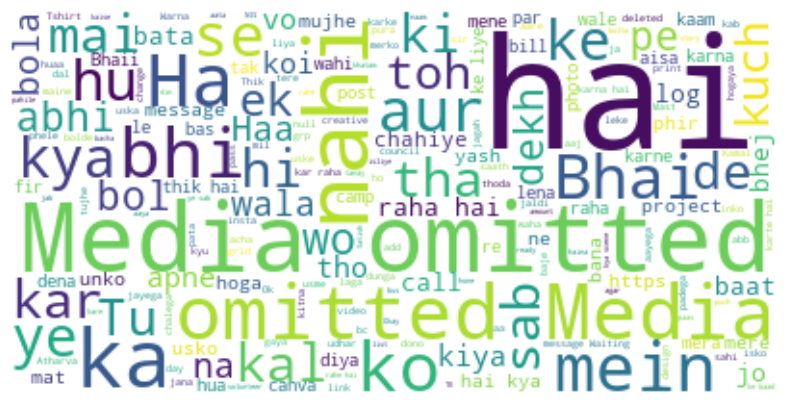

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Generate Word Cloud for the chat
text = " ".join(message for message in messages_df['Message'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)

# Plotting the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [7]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install vaderSentiment


Note: you may need to restart the kernel to use updated packages.


In [9]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [10]:
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to C:\Users\Satyam
[nltk_data]     Rudrakanthwar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
def sentiment_analysis(message):
    return analyzer.polarity_scores(message)

# Apply sentiment analysis to each message
messages_df['Sentiment'] = messages_df['Message'].apply(sentiment_analysis)


In [12]:
messages_df['Negativity'] = messages_df['Sentiment'].apply(lambda x: x['neg'])
messages_df['Neutrality'] = messages_df['Sentiment'].apply(lambda x: x['neu'])
messages_df['Positivity'] = messages_df['Sentiment'].apply(lambda x: x['pos'])
messages_df['Compound'] = messages_df['Sentiment'].apply(lambda x: x['compound'])


In [13]:
# Example: Average sentiment scores
average_negativity = messages_df['Negativity'].mean()
average_neutrality = messages_df['Neutrality'].mean()
average_positivity = messages_df['Positivity'].mean()
average_compound = messages_df['Compound'].mean()

print("Average Negativity:", average_negativity)
print("Average Neutrality:", average_neutrality)
print("Average Positivity:", average_positivity)
print("Average Compound Sentiment:", average_compound)


Average Negativity: 0.00965271068169619
Average Neutrality: 0.9136307031669351
Average Positivity: 0.07671551261406334
Average Compound Sentiment: 0.04084755770263017


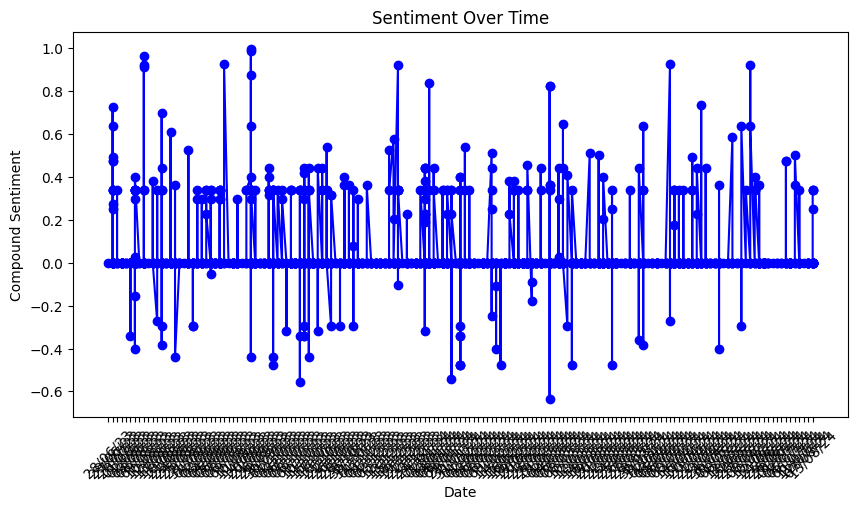

In [14]:
import matplotlib.pyplot as plt

# Plotting sentiment over time
plt.figure(figsize=(10, 5))
plt.plot(messages_df['Date'], messages_df['Compound'], marker='o', linestyle='-', color='b')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment')
plt.xticks(rotation=45)
plt.show()


In [15]:
# Ensure 'DateTime' column is created by combining 'Date' and 'Time' columns
messages_df['DateTime'] = pd.to_datetime(messages_df['Date'] + ' ' + messages_df['Time'], errors='coerce')

# Check if 'DateTime' column is created correctly
print(messages_df[['Date', 'Time', 'DateTime']].head())


       Date      Time            DateTime
0  28/06/23  11:15 pm 2023-06-28 23:15:00
1  29/06/23   7:54 am 2023-06-29 07:54:00
2  29/06/23   9:30 am 2023-06-29 09:30:00
3  29/06/23   7:35 pm 2023-06-29 19:35:00
4  29/06/23   7:43 pm 2023-06-29 19:43:00


C:\Users\Satyam Rudrakanthwar\AppData\Local\Temp\ipykernel_7580\139573465.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  messages_df['DateTime'] = pd.to_datetime(messages_df['Date'] + ' ' + messages_df['Time'], errors='coerce')


In [16]:
# Section: Response Time Analysis

# Calculate the time difference between consecutive messages
messages_df['PrevDateTime'] = messages_df['DateTime'].shift(1)
messages_df['ResponseTime'] = (messages_df['DateTime'] - messages_df['PrevDateTime']).dt.total_seconds() / 3600  # in minutes
messages_df['PrevAuthor'] = messages_df['Author'].shift(1)
messages_df['SameAuthor'] = messages_df['Author'] == messages_df['PrevAuthor']

# Filter out the messages that are not responses (i.e., consecutive messages from the same author)
response_times = messages_df[~messages_df['SameAuthor']]['ResponseTime']

# Calculate average response time
average_response_time = response_times.mean()
print(f"Average Response Time: {average_response_time:.2f} minutes")


Average Response Time: 13.82 minutes


In [17]:
# Section: Creating the 'Hour' column

# Extract the hour from the 'DateTime' column
messages_df['Hour'] = messages_df['DateTime'].dt.hour

# Check if the 'Hour' column is created correctly
print(messages_df[['DateTime', 'Hour']].head())


             DateTime  Hour
0 2023-06-28 23:15:00    23
1 2023-06-29 07:54:00     7
2 2023-06-29 09:30:00     9
3 2023-06-29 19:35:00    19
4 2023-06-29 19:43:00    19


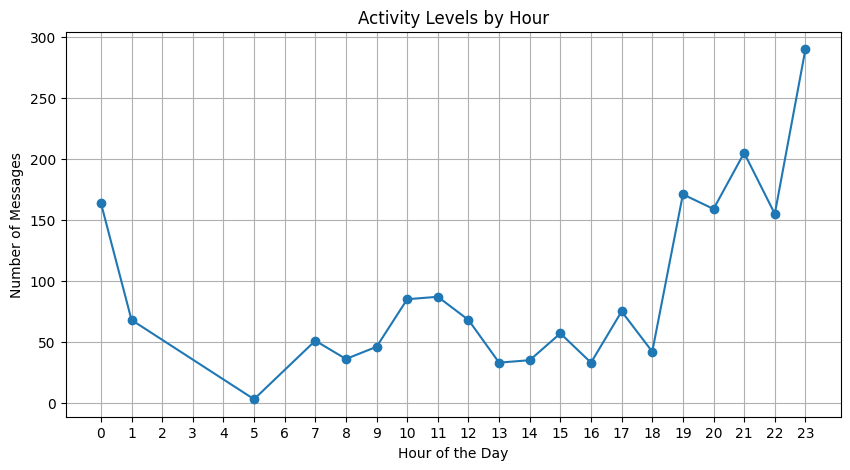

In [18]:
# Section: Active Hours Analysis

# Group the data by the hour of the day to analyze activity levels
hourly_activity = messages_df.groupby('Hour').size()

# Plotting the activity per hour
plt.figure(figsize=(10, 5))
plt.plot(hourly_activity.index, hourly_activity.values, marker='o')
plt.title('Activity Levels by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


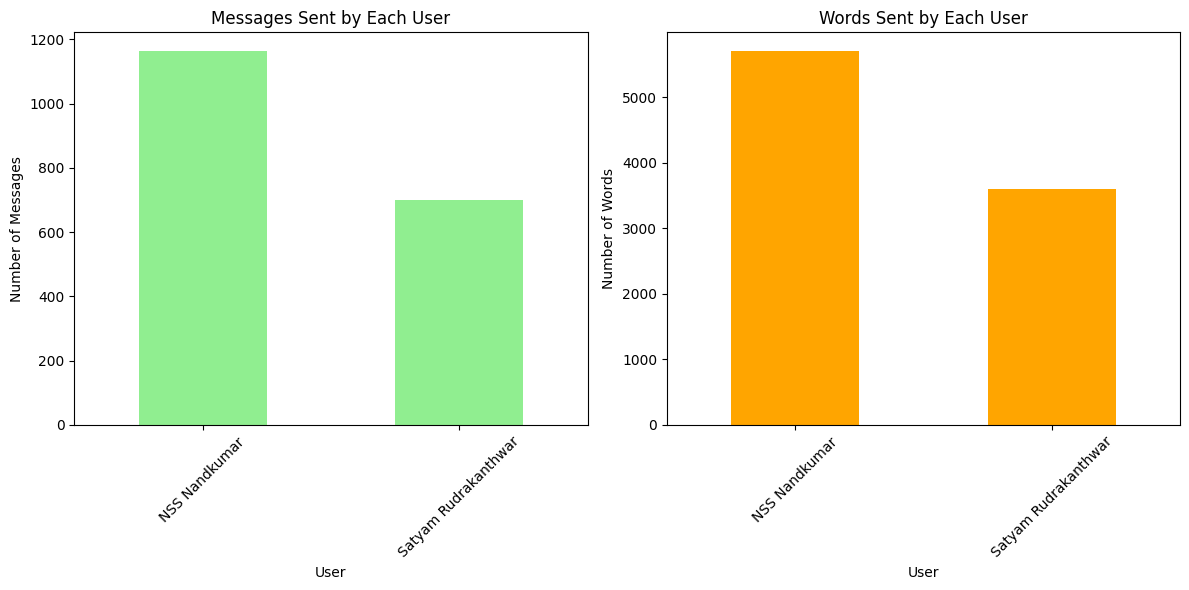


User Engagement Insights:
Author
NSS Nandkumar           1164
Satyam Rudrakanthwar     699
Name: count, dtype: int64

Words Per User:
Author
NSS Nandkumar           5704
Satyam Rudrakanthwar    3594
Name: Message, dtype: int64


In [19]:
# Section: User Engagement

# Count the number of messages sent by each user
user_engagement = messages_df['Author'].value_counts()

# Calculate the number of words sent by each user
user_words = messages_df.groupby('Author')['Message'].apply(lambda x: ' '.join(x)).apply(lambda x: len(x.split()))

# Plotting the user engagement data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
user_engagement.plot(kind='bar', color='lightgreen')
plt.title('Messages Sent by Each User')
plt.xlabel('User')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
user_words.plot(kind='bar', color='orange')
plt.title('Words Sent by Each User')
plt.xlabel('User')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print out engagement insights
print("\nUser Engagement Insights:")
print(user_engagement)
print("\nWords Per User:")
print(user_words)


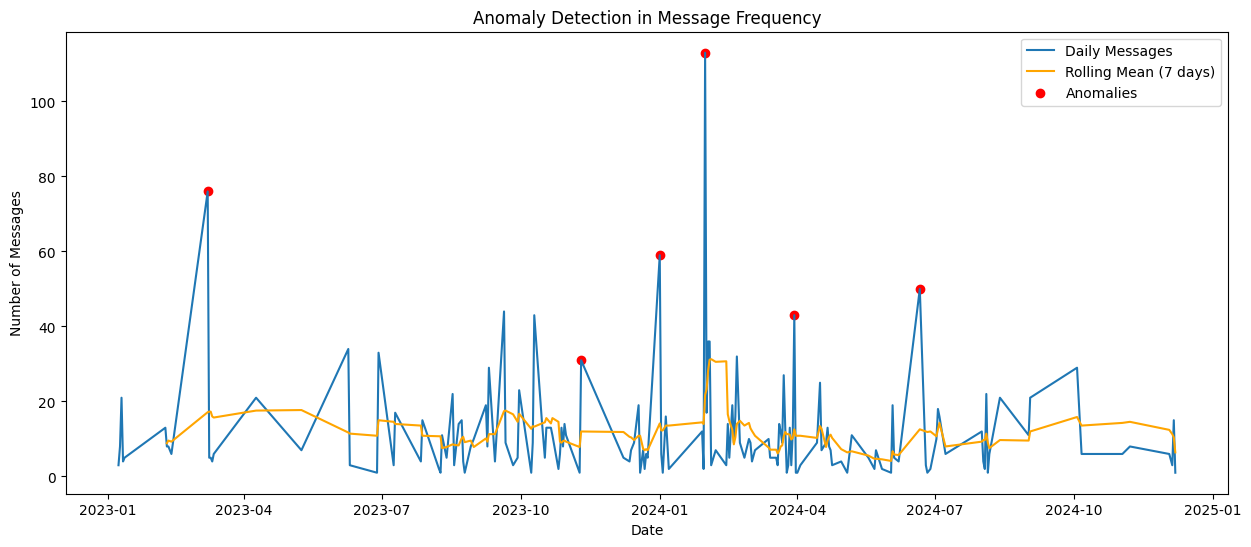

Detected Anomalies:
 DateTime
2023-03-08     76
2023-11-10     31
2024-01-01     59
2024-01-31    113
2024-03-30     43
2024-06-21     50
dtype: int64


In [20]:
# Section: Anomaly Detection in Message Frequency

# Group by date and count the number of messages per day
daily_messages = messages_df.groupby(messages_df['DateTime'].dt.date).size()

# Calculate the rolling mean and standard deviation
rolling_mean = daily_messages.rolling(window=7).mean()
rolling_std = daily_messages.rolling(window=7).std()

# Define an anomaly if the number of messages is more than 2 standard deviations away from the mean
anomalies = daily_messages[(daily_messages - rolling_mean).abs() > 2 * rolling_std]

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(daily_messages.index, daily_messages, label='Daily Messages')
plt.plot(rolling_mean.index, rolling_mean, color='orange', label='Rolling Mean (7 days)')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies', marker='o')
plt.title('Anomaly Detection in Message Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.legend()
plt.show()

# Print detected anomalies
print("Detected Anomalies:\n", anomalies)
